##**Importing Necessary Libraries**





In [ ]:
# Import necessary modules first.
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

# Loading the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/UTKFace.zip'

Streaming output truncated to the last 5000 lines.
  inflating: crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104204327523.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170105164106036.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170105172720493.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170108224608753.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170109140259136.jpg.

# Creating Directory for Dataset

In [ ]:
BASE_DIR = '/content/UTKFace'
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)
  img_components = image.split('_')
  age_label = int(img_components[0])
  gender_label = int(img_components[1])

  # Append the image_path, age_label, and gender_label
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')

Number of age_labels: 23708, Number of gender_labels: 23708, Number of image_paths: 23708


In [ ]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

# Displaying First 5 Data

In [ ]:
import pandas as pd
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(5)

,image_path,age,gender
0,/content/UTKFace/2_0_2_20161219141211674.jpg.c...,2,0
1,/content/UTKFace/49_0_0_20170117163226874.jpg....,49,0
2,/content/UTKFace/37_0_2_20170116192041226.jpg....,37,0
3,/content/UTKFace/27_0_2_20170104192852607.jpg....,27,0
4,/content/UTKFace/30_1_3_20170109134515826.jpg....,30,1


# EXPLORATORY DATA ANALYSIS




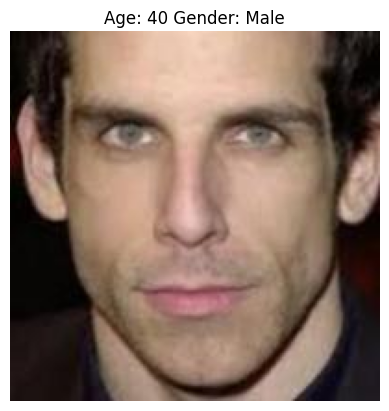

In [ ]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

<Axes: xlabel='age', ylabel='Density'>

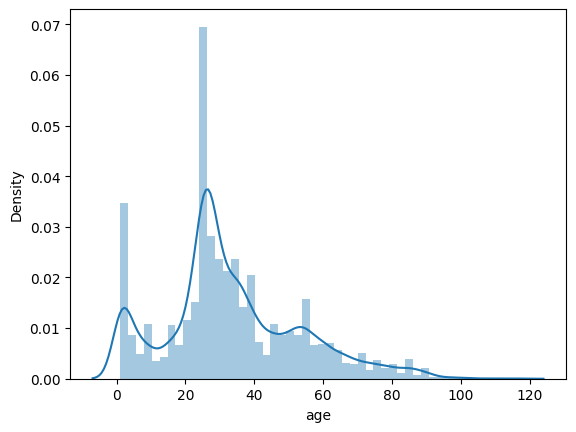

In [ ]:
# Age distribution
sns.distplot(df['age'])

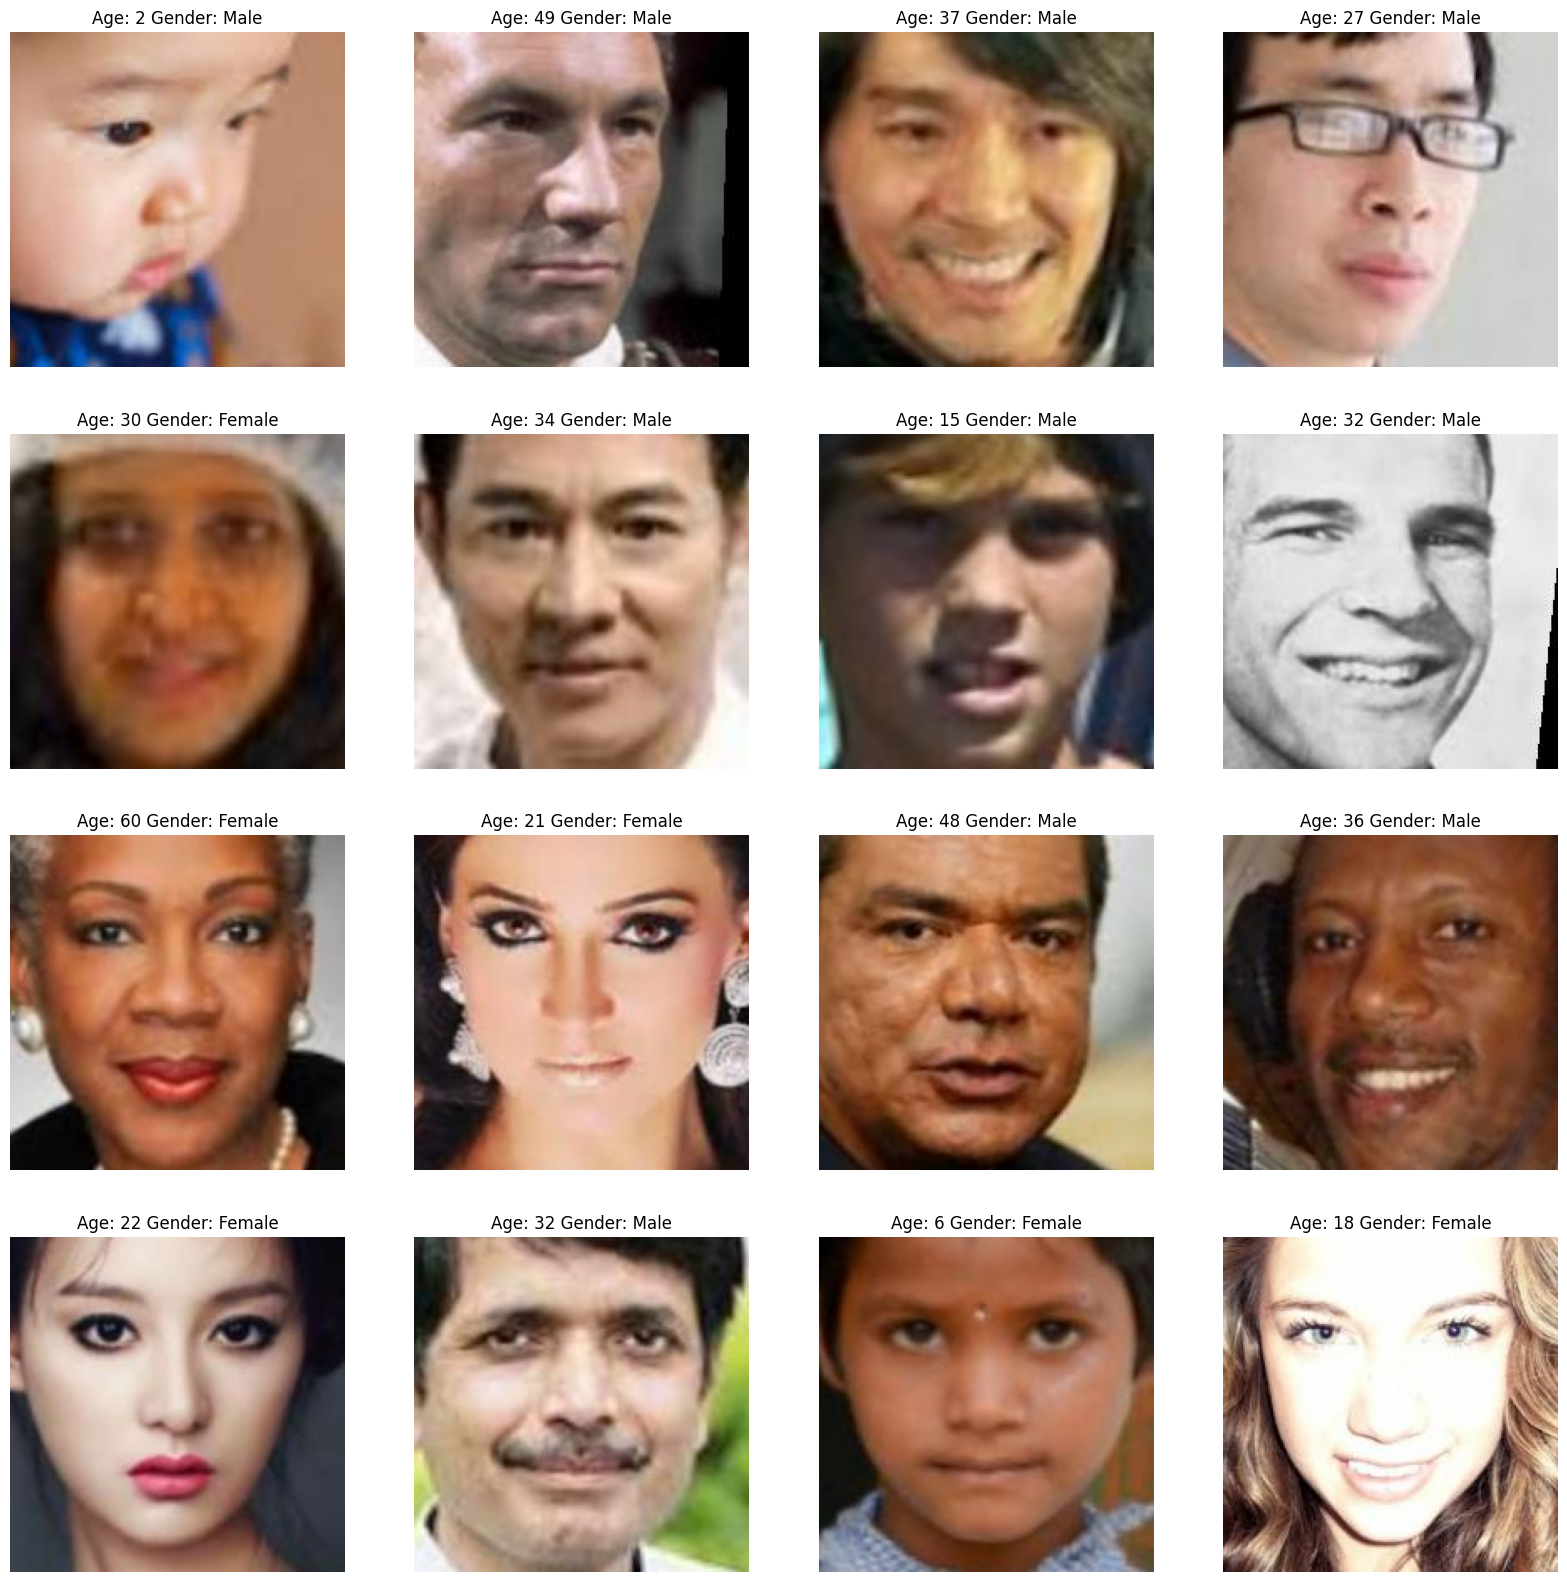

In [ ]:
plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, age, gender in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
    plt.imshow(img)

# FEATURE EXTRACTION

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tqdm import tqdm

def extract_image_features(images):
    image_features = []

    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')  # Load the image in grayscale mode
        img = img.resize((128, 128))  # Resize the image to 128x128
        img = img_to_array(img)  # Convert image to array
        img = img / 255.0  # Normalize the image
        image_features.append(img)

    return np.array(image_features).reshape(-1, 128, 128, 1)  # Reshape for the model

# Now you can use the function to extract features
X = extract_image_features(df['image_path'])

100%|██████████| 23708/23708 [00:31<00:00, 750.59it/s]


In [ ]:
X.shape

(23708, 128, 128, 1)

In [ ]:
X = X / 255.0

In [ ]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [ ]:
input_shape = (128, 128, 1)

# MODEL TRAINING

In [ ]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam',
              metrics=[['accuracy'], ['mae']]) # Provide a list of metrics for each output

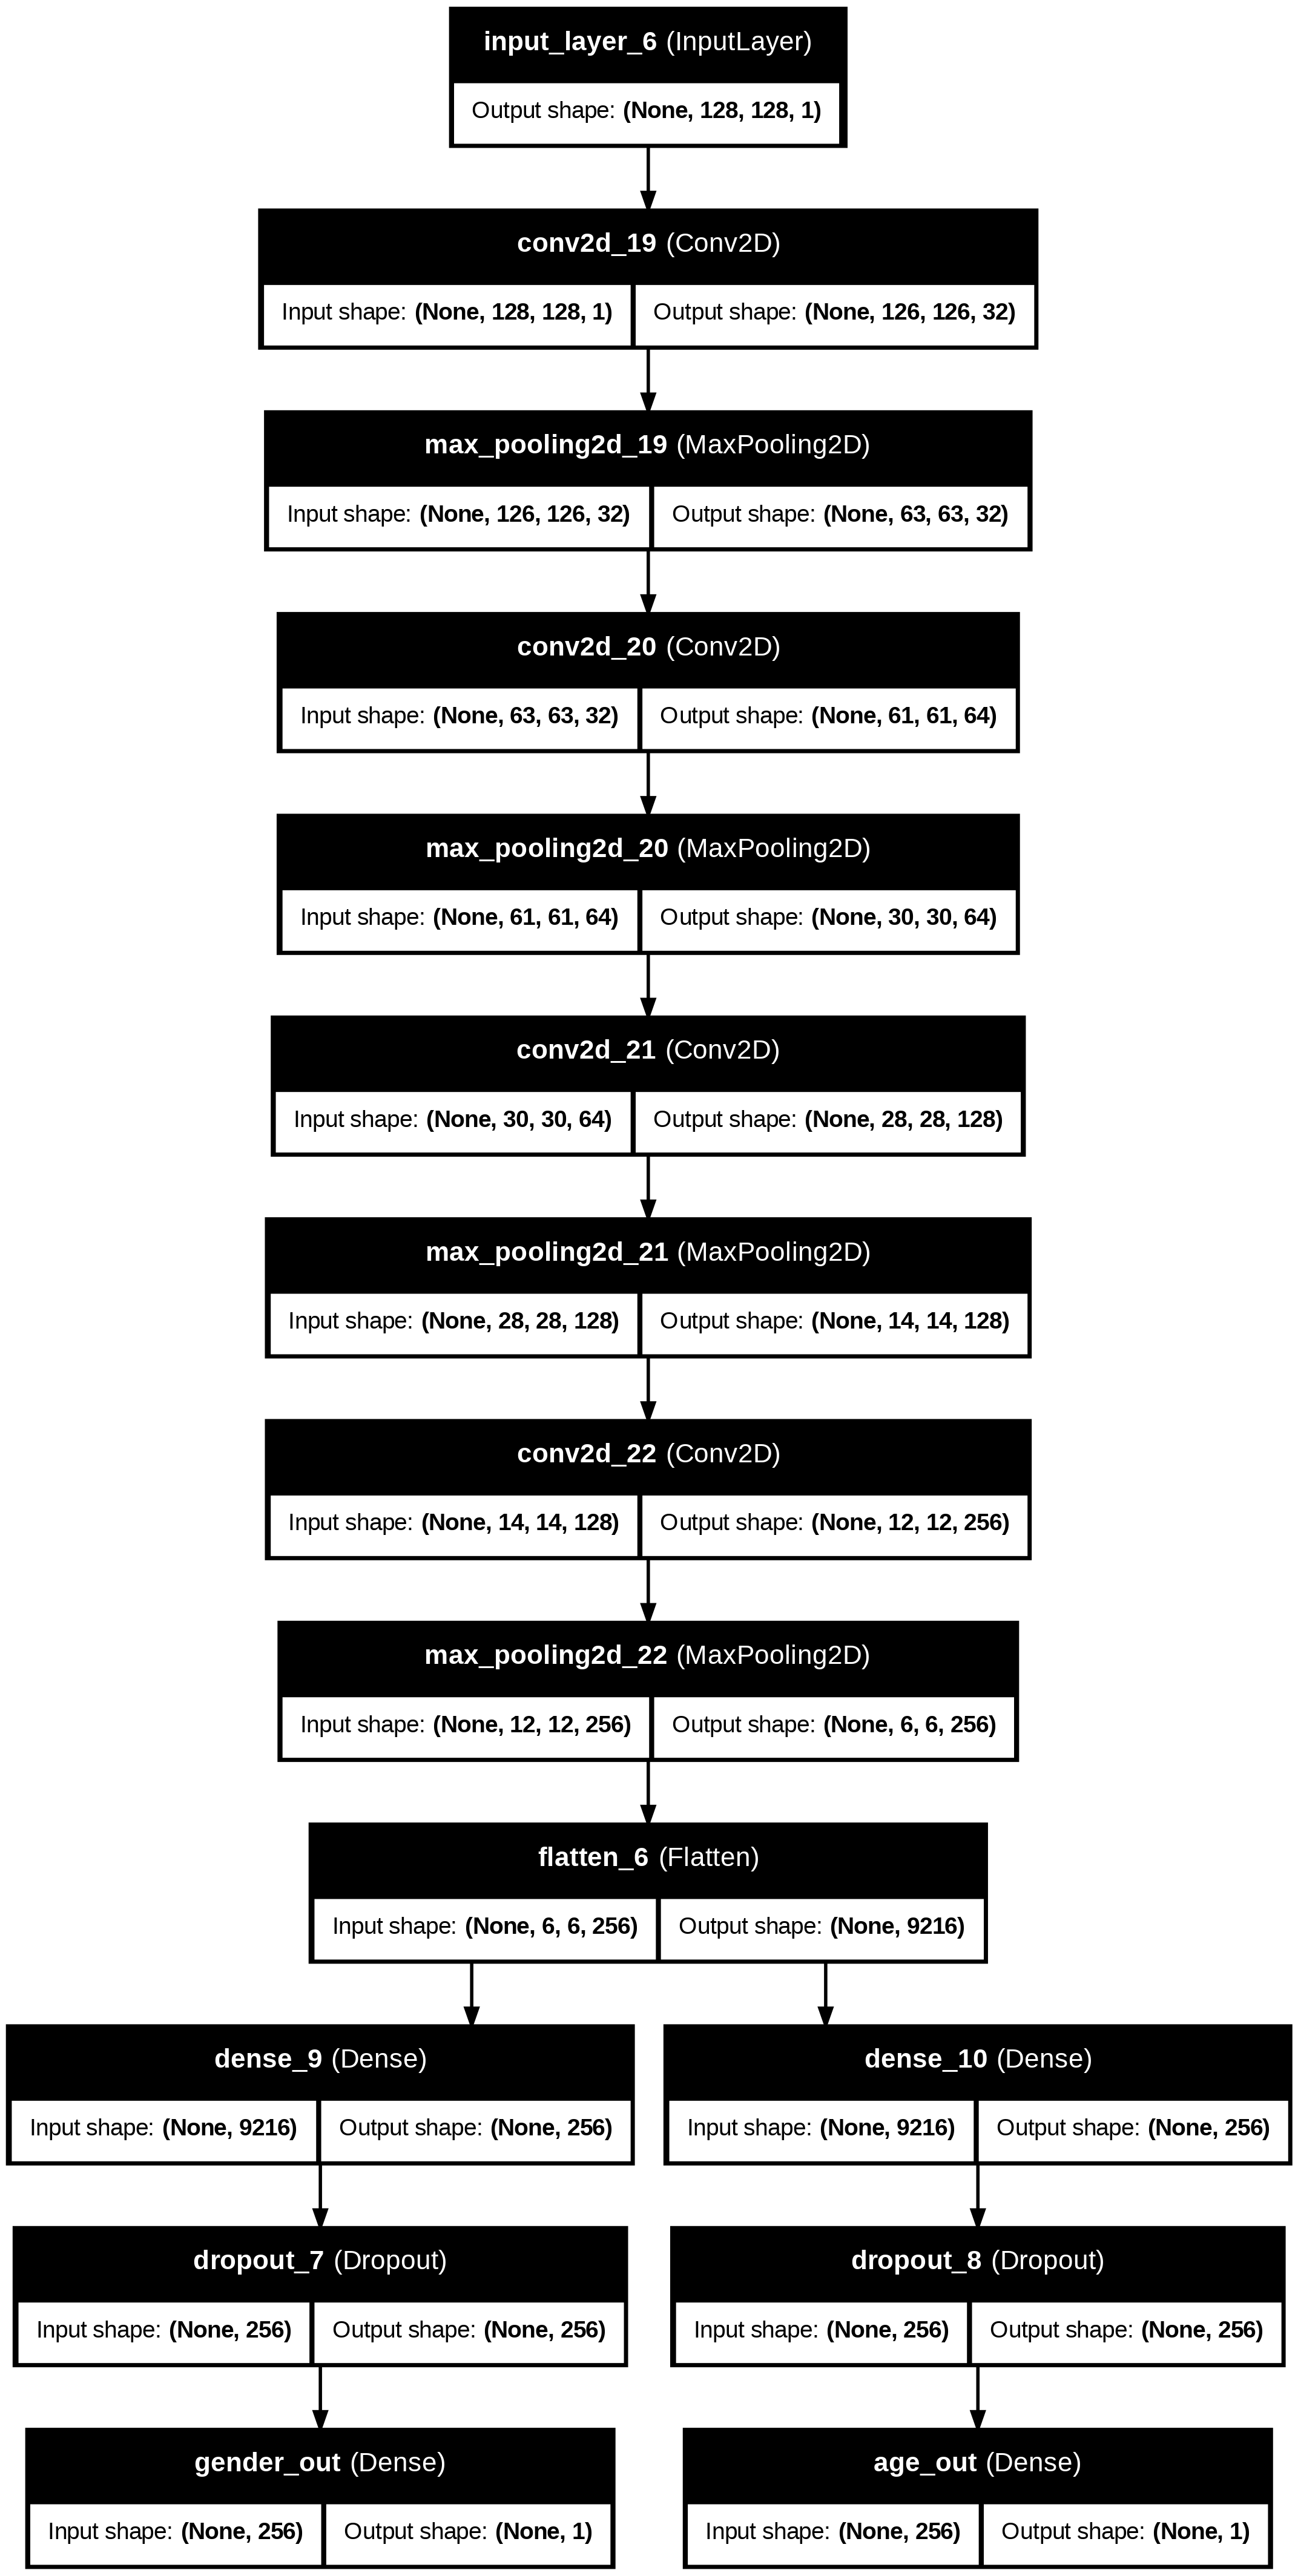

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=50, validation_split=0.2)


Epoch 1/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - age_out_mae: 17.0086 - gender_out_accuracy: 0.5180 - loss: 17.7071 - val_age_out_mae: 14.9890 - val_gender_out_accuracy: 0.5261 - val_loss: 15.6811
Epoch 2/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - age_out_mae: 15.3816 - gender_out_accuracy: 0.5238 - loss: 16.0738 - val_age_out_mae: 15.0964 - val_gender_out_accuracy: 0.5261 - val_loss: 15.7883
Epoch 3/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - age_out_mae: 15.3725 - gender_out_accuracy: 0.5258 - loss: 16.0645 - val_age_out_mae: 14.9244 - val_gender_out_accuracy: 0.5261 - val_loss: 15.6162
Epoch 4/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - age_out_mae: 15.1300 - gender_out_accuracy: 0.5241 - loss: 15.8220 - val_age_out_mae: 14.9260 - val_gender_out_accuracy: 0.5261 - val_loss: 15.6179
Epoch 5/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - age_out_mae: 15.3791 - gender_out_accuracy: 0.5195 - loss: 16.0716 - val_age_out_mae: 14.9272 - val_gender_out_accuracy: 0.5261 

# Plot Result For Age

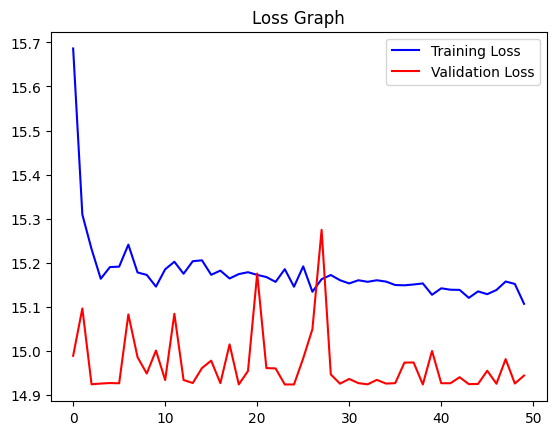

In [ ]:
# plot results for age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae'] # Use 'mae' instead of 'loss' for age output
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

# Predicting Test Data

In [ ]:
def get_image_features(image):
  img = load_img(image, grayscale=True)
  img = img.resize((128, 128), Image.ANTIALIAS)
  img = np.array(img)
  img = img.reshape(1, 128, 128, 1)
  img = img / 255.0
  return img


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def get_image_features(image_path):
    # Load the image in grayscale mode
    img = load_img(image_path, color_mode='grayscale')
    img = img.resize((128, 128))  # Resize the image to 128x128
    img = img_to_array(img)  # Convert the image to an array
    img = img.reshape(1, 128, 128, 1)  # Reshape for the model input
    img = img.astype('float32') / 255.0  # Normalize the image
    return img

# Example usage
img_to_test = '/content/UTKFace/10_0_1_20170110223848885.jpg.chip.jpg'
features = get_image_features(img_to_test)
pred = model.predict(features)

# Print raw predictions
print("Raw predictions:", pred)

# Assuming gender_mapping is defined correctly
gender_mapping = {0: 'Male', 1: 'Female'}  # Adjust as needed

# Process and print the predicted values
gender = gender_mapping[round(pred[0][0][0])]
age = round(pred[1][0][0])

print(f"Predicted Gender: {gender}")
print(f"Predicted Age: {age}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Raw predictions: [array([[0.47670823]], dtype=float32), array([[37.15551]], dtype=float32)]
Predicted Gender: Male
Predicted Age: 37
